# MNIST Number Classification with ANN


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_data_loaders(batch_size = 64): #if memory is low reduce batch size
  transform = transforms.Compose([
      transforms.ToTensor(), #change image to tensor and 0-255
      transforms.Normalize((0.5,), (0.5,)) #pixel -1,1 scaling
  ])

  #mnist data load and create train data sets
  train_set = torchvision.datasets.MNIST(root = "./data", train=True, download=True, transform=transform)
  test_set = torchvision.datasets.MNIST(root = "./data", train=False, download=True, transform=transform)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [8]:
train_loader, test_loader = get_data_loaders()

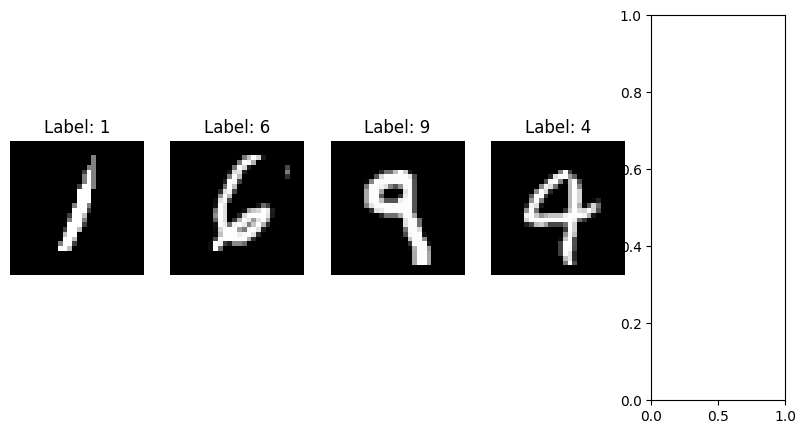

In [12]:
#data visualization
def visualize_samples(loader,n):
  images, labels = next(iter(loader)) #take image and label from first batch
  fig, axes = plt.subplots(1,5,figsize=(10,5)) #n different image visualization
  for i in range(n):
    axes[i].imshow(images[i].squeeze(), cmap="gray") #black and white image
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
  plt.show()

visualize_samples(train_loader, 4)

### define ann model

In [14]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    #turn image to vector (1D)
    self.flatten = nn.Flatten()

    #create first layer
    self.fc1 = nn.Linear(28*28,128) #input size = 784, output size = 128

    #activation functions
    self.relu = nn.ReLU()

    #second layer
    self.fc2 = nn.Linear(128,64) #input = 128, output = 64 (usually half of input)

    #output layer
    self.fc3 = nn.Linear(64,10) #input = 64, output = 10 (number of classes)
  def forward(self, x):
    #initial x = 28*28 flatten 784 vector
    x = self.flatten(x)
    x = self.fc1(x) #first layer
    x = self.relu(x) #activation function
    x = self.fc2(x) #second layer
    x = self.fc3(x) #output
    return x

In [27]:
model = NeuralNetwork().to(device)

In [28]:
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(), # cross entropy loss multi-class classification
    optim.Adam(model.parameters(), lr=0.001) #update weights with ADAM
)

criterion, optimizer = define_loss_and_optimizer(model)

## training model

Epoch 1/5, Loss: 0.1336
Epoch 2/5, Loss: 0.1077
Epoch 3/5, Loss: 0.0960
Epoch 4/5, Loss: 0.0846
Epoch 5/5, Loss: 0.0768


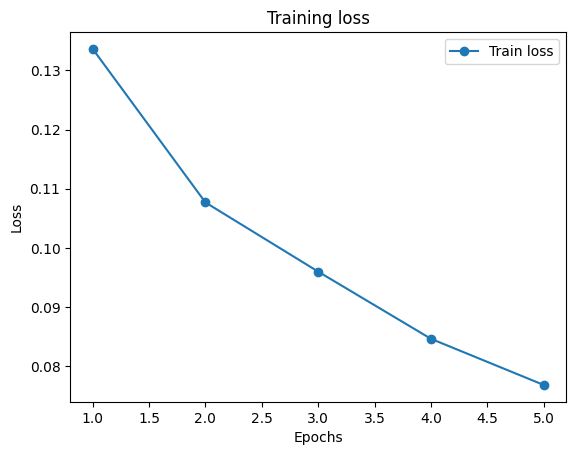

In [31]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
  #train model
  model.train()

  #list for every epoch loss
  train_losses = []

  #train for specified epoch
  for epoch in range(epochs):
    total_loss = 0 #total loss
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      predictions = model(images)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()
      total_loss = total_loss + loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
  plt.figure()
  plt.plot(range(1,epochs+1), train_losses, marker="o", linestyle="-", label= "Train loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training loss")
  plt.legend()
  plt.show()

train_model(model, train_loader, criterion, optimizer, epochs = 5)

In [32]:
def test_model(model, test_loader):
  model.eval() #evaluate model
  correct = 0 #correct prediction count
  total = 0 #total data count

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      predictions = model(images)

      _, predicted = torch.max(predictions, 1) #highest probability class label
      total += labels.size(0) #update total data
      correct += (predicted == labels).sum().item()

  print(f"Test accuracy: {100* correct/total :.3f}%")

test_model(model, test_loader)

Test accuracy: 96.620%


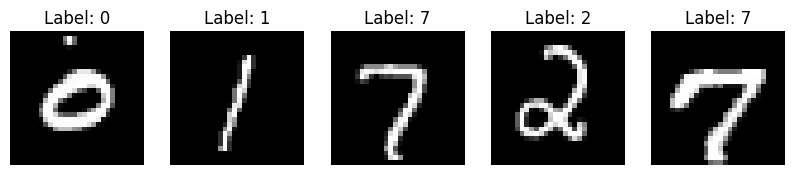

Epoch 1/10, Loss: 0.3615
Epoch 2/10, Loss: 0.1702
Epoch 3/10, Loss: 0.1275
Epoch 4/10, Loss: 0.1084
Epoch 5/10, Loss: 0.0987
Epoch 6/10, Loss: 0.0851
Epoch 7/10, Loss: 0.0771
Epoch 8/10, Loss: 0.0723
Epoch 9/10, Loss: 0.0647
Epoch 10/10, Loss: 0.0648


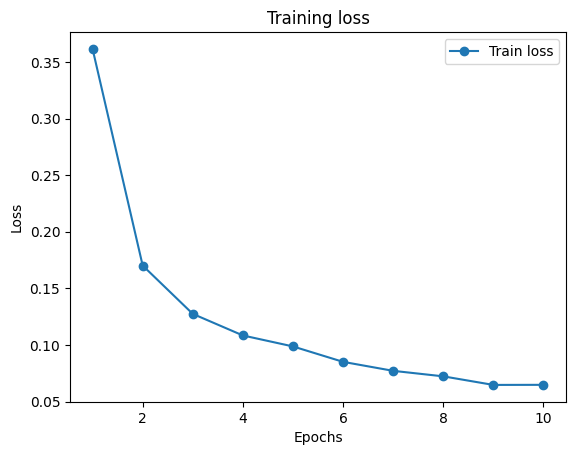

Test accuracy: 97.130%


In [33]:
if __name__ == "__main__":
  train_loader, test_loader = get_data_loaders()
  visualize_samples(train_loader, 5)
  model = NeuralNetwork().to(device)
  criterion, optimizer = define_loss_and_optimizer(model)
  train_model(model, train_loader, criterion, optimizer)
  test_model(model, test_loader)